In [1]:
import IP
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from skimage.measure import label
from skimage.transform import pyramid_laplacian

In [67]:
I1 = IP.imread('walking_bright.tiff')/65535
I2 = IP.imread('walking_mid.tiff')/65535
I3 = IP.imread('walking_dark.tiff')/65535

In [91]:
I4 = IP.imread('tiecheng_bright.jpg')/255
I5 = IP.imread('tiecheng_mid.jpg')/255
I6 = IP.imread('tiecheng_dark.jpg')/255

In [110]:
I7 = IP.imread('flag_bright.jpg')/255
I8 = IP.imread('flag_mid.jpg')/255
I9 = IP.imread('flag_dark.jpg')/255

In [140]:
I10 = IP.imread('library_bright.jpg')/255
I11 = IP.imread('library_mid.jpg')/255
I12 = IP.imread('library_dark.jpg')/255

In [156]:
I13 = IP.imread('car_bright.jpg')/255
I14 = IP.imread('car_mid.jpg')/255
I15 = IP.imread('car_dark.jpg')/255

In [176]:
I16 = IP.imread('cafe_bright.tiff')/65535
I17 = IP.imread('cafe_mid.tiff')/65535
I18 = IP.imread('cafe_dark.tiff')/65535

In [151]:
I22 = IP.imread('gallery_bright.jpg')/255
I23 = IP.imread('gallery_mid.jpg')/255
I24 = IP.imread('gallery_dark.jpg')/255

##This part below is for ghost detection

In [4]:
def im2bw(Ig,level):
    S=np.copy(Ig)
    S[Ig > level] = 1
    S[Ig <= level] = 0
    return(S)

In [184]:
#imshow(Bit_map(I13,I14,I15,4,17),cmap='gray')

In [5]:
def Bit_map(I1,I2,I3,e,d):
    I1 = IP.rgb2gray(I1)
    I2 = IP.rgb2gray(I2)
    I3 = IP.rgb2gray(I3)
    med1 = median(I1);
    med2 = median(I2);
    med3 = median(I3);
    med_map1 = im2bw(I1,med1)
    med_map2 = im2bw(I2,med2)
    med_map3 = im2bw(I3,med3)
    G = zeros((I1.shape[0],I1.shape[1]))
    S = med_map1 + med_map2 + med_map3
    G[where(S==0)] = 0
    G[where(S==3)] = 0
    G[where(S==1)] = 1
    G[where(S==2)] = 1
#     for i in range(0,I1.shape[0]):
#         for j in range(0,I1.shape[1]):
#             S = med_map1[i,j]+med_map2[i,j]+med_map3[i,j]
#             if S == 3 or S == 0:
#                 G[i,j]=0
#             else:
#                 G[i,j]=1
    G = IP.imerode(G,IP.disk(e))
    G = IP.imdilate(G,IP.disk(d))
    return G

In [6]:
def Label_object(I):
    L,num = label(I,background=0,connectivity=1,return_num=True)
    return L,num

In [7]:
def Contrast(I,sigma):
    I = IP.rgb2gray(I)
    C = IP.nd.filters.gaussian_laplace(I,sigma)
    C = C - C.min()
    return C/C.max()

In [8]:
def Saturation(I):
    R = I[:,:,0]
    G = I[:,:,1]
    B = I[:,:,2]
    S = zeros((I.shape[0],I.shape[1]))
    M = (R + G + B)/3
    S = sqrt(((R-M)**2 + (G-M)**2 + (B-M)**2)/3)
#     for i in range(0,I.shape[0]):
#         for j in range(0,I.shape[1]):
#             S[i,j] = std((R[i,j],G[i,j],B[i,j]))
    return S 

In [9]:
def Exposedness(I,sigma):
    R = I[:,:,0]
    G = I[:,:,1]
    B = I[:,:,2]
    R_E = Gaussian_curve(R,sigma)
    G_E = Gaussian_curve(G,sigma)
    B_E = Gaussian_curve(B,sigma)
    E = R_E * G_E * B_E
    return E

In [10]:
def Gaussian_curve(pixel,sigma):
    E = exp(-(pixel-0.5)**2/(2*sigma**2))
    return E

In [11]:
def weight_map(I,sigma):
    C = Contrast(I,4) 
    S = Saturation(I)
    E = Exposedness(I,sigma)
    
    C = C + 10
    S = S + 10
    E = E + 10
    
    W = C*S*E
    
    return W

### The function below generate HDR

In [179]:
def HDR_Integration(I1,I2,I3):
    G = Bit_map(I1,I2,I3,4,10)
    L,num = Label_object(G)
    w1 = weight_map(I1,0.4)
    w2 = weight_map(I2,0.2)
    w3 = weight_map(I3,0.2)
    print('weight map computed')
    nw1 = (w1)/(w1+w2+w3)
    nw2 = (w2)/(w1+w2+w3)
    nw3 = (w3)/(w1+w2+w3)
    
    R = zeros((I1.shape[0],I1.shape[1],3))
    
    bg= where(L==-1)
    R[bg[0],bg[1],0] = I1[bg[0],bg[1],0]*nw1[bg[0],bg[1]] +\
                       I2[bg[0],bg[1],0]*nw2[bg[0],bg[1]] +\
                       I3[bg[0],bg[1],0]*nw3[bg[0],bg[1]] 
    
    R[bg[0],bg[1],1] = I1[bg[0],bg[1],1]*nw1[bg[0],bg[1]] +\
                       I2[bg[0],bg[1],1]*nw2[bg[0],bg[1]] +\
                       I3[bg[0],bg[1],1]*nw3[bg[0],bg[1]] 
    
    R[bg[0],bg[1],2] = I1[bg[0],bg[1],2]*nw1[bg[0],bg[1]] +\
                       I2[bg[0],bg[1],2]*nw2[bg[0],bg[1]] +\
                       I3[bg[0],bg[1],2]*nw3[bg[0],bg[1]] 
    print('back ground generated')
    
    for i in range(1,num+1):
        lab = where(L == i)
        a = sum(nw1[lab[0],lab[1]])
        b = sum(nw2[lab[0],lab[1]])
        c = sum(nw3[lab[0],lab[1]])  
        if a > b and a > c:
            R[lab[0],lab[1],:] = I2[lab[0],lab[1],:]
        elif b > a and b > c:
            R[lab[0],lab[1],:] = I2[lab[0],lab[1],:]
        elif c > a and c > b:
            R[lab[0],lab[1],:] = I2[lab[0],lab[1],:]
    return R
    

In [180]:
T2 = HDR_Integration(I16,I17,I18)

weight map computed
back ground generated


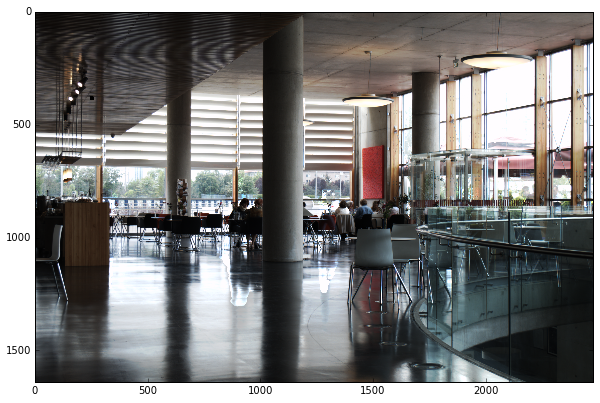

In [181]:
figure(figsize=(10,10))
imshow(T2)

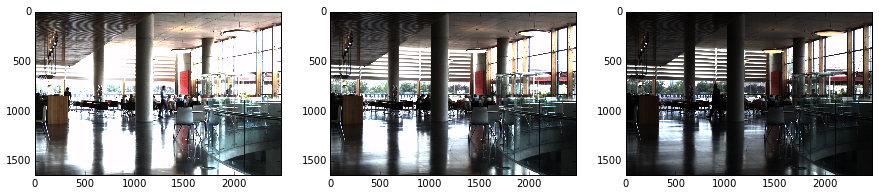

In [183]:
fig,((ax1,ax2,ax3))=subplots(1,3,figsize=(15,15))
ax1.imshow(I16)
ax2.imshow(I17)
ax3.imshow(I18)

In [182]:
imsave('cafe_merge.jpg',T2)

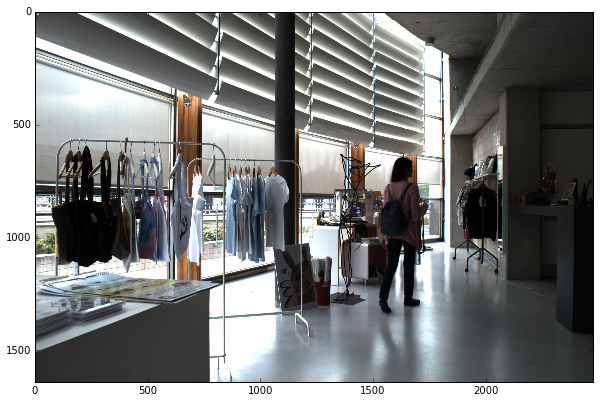

In [53]:
figure(figsize=(10,10))
imshow(I2)